# Import libraries

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers.experimental.preprocessing import Normalization
import matplotlib.pyplot as plt


In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:


raw_train_ds = preprocessing.text_dataset_from_directory(
   '/content/drive/MyDrive/MasterThesis/Datasets/Offensive2020/train',
    batch_size=BATCH_SIZE,
    seed=1070
    )

raw_test_ds = preprocessing.text_dataset_from_directory(
    '/content/drive/MyDrive/MasterThesis/Datasets/Offensive2020/test',
     batch_size=BATCH_SIZE)

raw_val_ds = preprocessing.text_dataset_from_directory(
    '/content/drive/MyDrive/MasterThesis/Datasets/Offensive2020/dev',
     batch_size=BATCH_SIZE)

Found 7000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "/content/drive/MyDrive/MasterThesis/Datasets/Offensive2020/all",
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="training",
    seed=1337,
)
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "/content/drive/MyDrive/MasterThesis/Datasets/Offensive2020/all",
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=1337,
)
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "/content/drive/MyDrive/MasterThesis/Datasets/Offensive2020/test", batch_size=BATCH_SIZE
)

Found 1006 files belonging to 1 classes.
Using 805 files for training.
Found 1006 files belonging to 1 classes.
Using 201 files for validation.
Found 2000 files belonging to 2 classes.


In [ ]:
raw_train_ds.class_names

['NOT_HS']

In [ ]:
raw_train_ds = raw_train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
raw_test_ds = raw_test_ds.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
raw_val_ds = raw_val_ds.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
raw_train_ds = raw_train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
raw_val_ds = raw_val_ds.batch(BATCH_SIZE)

In [ ]:
raw_train_ds.take(1)

<TakeDataset shapes: ((None,), (None,)), types: (tf.string, tf.int32)>

In [ ]:
for tweet_batch, label_batch in raw_train_ds.take(1):
  for i in range(5):
    print("tweet: ", tweet_batch[i].numpy().decode('utf-8').strip())
    print("Label: ", label_batch[i].numpy())

InvalidArgumentError: ignored

In [ ]:
import string
import re
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    # stripped_html = tf.strings.regex_replace(lowercase, "<LF>", " ")
    stripped_html = tf.strings.regex_replace(input_data, "[a-zA-Z]|[.،,!?؟\\-]", " ")
    # stripped_html = tf.strings.regex_replace(input_data, ".", " ")
    #  strip(string.punctuation)
    return tf.strings.regex_replace(
       
        stripped_html, "[%s]" % re.escape(string.punctuation), ""
    )
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=10000,
    output_mode='int'
    # output_sequence_length=MAX_SEQUENCE_LENGTH
    )
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda text, labels: text)
vectorize_layer.adapt(train_text)


In [ ]:
# raw_val_ds = raw_val_ds.map(lambda text, labels: text)
# vectorize_layer.adapt(raw_val_ds)

In [ ]:
vocab = np.array(vectorize_layer.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'يا', 'و', 'من', 'الله', 'في', 'ما', 'رب', 'لا', 'كل',
       'على', 'انت', 'اللهم', 'انا', 'اللي', 'ولا', 'والله', 'قلبي',
       'عليك'], dtype='<U53')

In [ ]:
vectorize_layer


In [ ]:
encoded_example = vectorize_layer(tweet_batch)[:20].numpy()
encoded_example

array([[   7,   27,    2, ...,    0,    0,    0],
       [   1,  285,    1, ...,    0,    0,    0],
       [   2, 1429,    2, ...,    0,    0,    0],
       ...,
       [  33,   48,    2, ...,    0,    0,    0],
       [   2, 2293,    2, ...,    0,    0,    0],
       [   1,    2,    1, ...,    0,    0,    0]])

In [ ]:
for n in range(5):
  print("Original: ", tweet_batch[n].numpy().decode('utf-8').strip())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  RT @USER: ما هو يا اذاكر يا انام البعملوا ده مش هينفع والله	NOT_OFF	NOT_HS
Round-trip:  ما هو يا اذاكر يا انام [UNK] ده مش هينفع والله                                         

Original:  @USER نبكي أم نضحك يا بيك! يا عروبي يا مناضل يا "خليفة" كمال جنبلاط ! نبكي أم نضحك ؟ URL	NOT_OFF	NOT_HS
Round-trip:  [UNK] أم [UNK] يا بيك يا [UNK] يا [UNK] يا خليفة كمال [UNK] [UNK] أم [UNK] ؟                                   

Original:  يا نوم يا نعال رح لرتاااج	NOT_OFF	NOT_HS
Round-trip:  يا نوم يا نعال رح [UNK]                                              

Original:  يا أحسنَ الناسِ يا من لا أبوحُ به<LF>يا مَنْ تَجَنّى وَما أحْلى تَجَنّيهِ.	NOT_OFF	NOT_HS
Round-trip:  يا [UNK] [UNK] يا من لا [UNK] به يا مَنْ [UNK] وَما [UNK] [UNK]                                      

Original:  @USER تكسب الرهان يا إتش يا أغلى الغاليين URL	NOT_OFF	NOT_HS
Round-trip:  تكسب [UNK] يا [UNK] يا أغلى [UNK]                                             



# First model with one RNN layer - Bidirectional

In [ ]:
model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(
        input_dim=len(vectorize_layer.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
# predict on a sample text without padding.

sample_text = ('وانت يا لص يا متصهين لا تمثل المجتمع الكوردي')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[-3.088626]


In [ ]:

# predict on a sample text with padding

padding = " ال" * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.00563214]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
# raw_val_ds = raw_val_ds.shuffle(1000).batch(32)
# raw_train_ds=raw_train_ds.shuffle(7000).batch(32)

In [ ]:
history = model.fit(raw_train_ds, epochs=10,
                    validation_data=raw_val_ds, 
                    validation_steps=30)
                  
                  
                    # steps_per_epoch=30
                    

Epoch 1/10
110/110 [==============================] - 12s 107ms/step - loss: 0.6202 - accuracy: 0.3503 - val_loss: 0.5017 - val_accuracy: 0.8200
Epoch 2/10
110/110 [==============================] - 9s 83ms/step - loss: 0.5045 - accuracy: 0.7984
Epoch 3/10
110/110 [==============================] - 9s 83ms/step - loss: 0.4592 - accuracy: 0.7989
Epoch 4/10
110/110 [==============================] - 9s 80ms/step - loss: 0.3879 - accuracy: 0.8299
Epoch 5/10
110/110 [==============================] - 9s 80ms/step - loss: 0.2834 - accuracy: 0.9033
Epoch 6/10
110/110 [==============================] - 9s 81ms/step - loss: 0.1845 - accuracy: 0.9447
Epoch 7/10
110/110 [==============================] - 9s 81ms/step - loss: 0.1319 - accuracy: 0.9603
Epoch 8/10
110/110 [==============================] - 9s 80ms/step - loss: 0.0867 - accuracy: 0.9764
Epoch 9/10
110/110 [==============================] - 9s 80ms/step - loss: 0.0612 - accuracy: 0.9846
Epoch 10/10
110/110 [==========================

In [ ]:
test_loss, test_acc = model.evaluate(raw_test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

32/32 [==============================] - 2s 51ms/step - loss: 0.5191 - accuracy: 0.8745
Test Loss: 0.5190743207931519
Test Accuracy: 0.8744999766349792


(0.0, 0.6488910418003797)

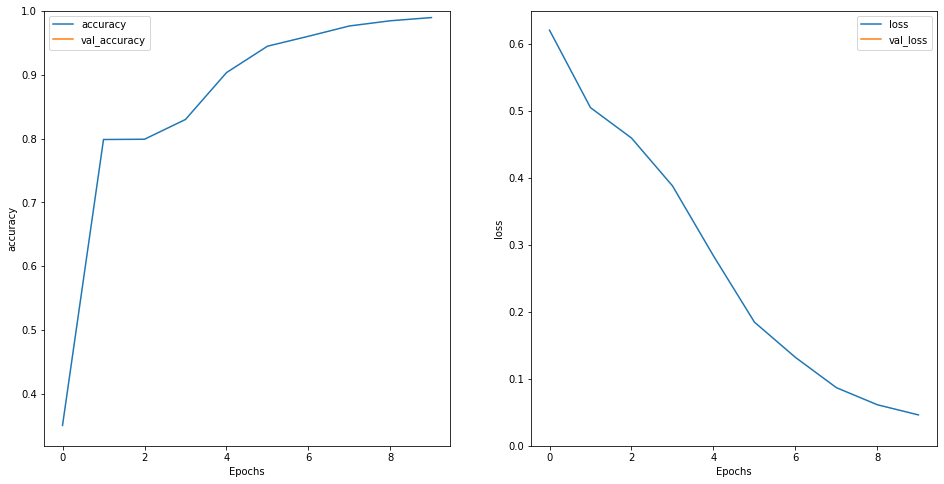

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)


In [ ]:
sample_text = ('وانت يا لص يا متصهين لا تمثل المجتمع الكوردي ')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[-3.088626]


Second model with two RNN layer - Bidirectional

In [ ]:
model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(len(vectorize_layer.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(raw_train_ds, epochs=10,
                    validation_data=raw_test_ds,
                    validation_steps=30)

Epoch 1/10
110/110 [==============================] - 16s 143ms/step - loss: 0.6301 - accuracy: 0.3404 - val_loss: 0.5391 - val_accuracy: 0.7688
Epoch 2/10
110/110 [==============================] - 12s 110ms/step - loss: 0.5212 - accuracy: 0.7629 - val_loss: 0.4862 - val_accuracy: 0.7990
Epoch 3/10
110/110 [==============================] - 12s 112ms/step - loss: 0.4495 - accuracy: 0.8031 - val_loss: 0.4091 - val_accuracy: 0.8089
Epoch 4/10
110/110 [==============================] - 12s 110ms/step - loss: 0.3180 - accuracy: 0.8850 - val_loss: 0.3658 - val_accuracy: 0.8656
Epoch 5/10
110/110 [==============================] - 12s 109ms/step - loss: 0.1926 - accuracy: 0.9373 - val_loss: 0.3424 - val_accuracy: 0.8687
Epoch 6/10
110/110 [==============================] - 12s 113ms/step - loss: 0.1167 - accuracy: 0.9664 - val_loss: 0.4304 - val_accuracy: 0.8729
Epoch 7/10
110/110 [==============================] - 13s 114ms/step - loss: 0.0752 - accuracy: 0.9800 - val_loss: 0.4918 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(raw_test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

32/32 [==============================] - 2s 56ms/step - loss: 0.6717 - accuracy: 0.8670
Test Loss: 0.6716986894607544
Test Accuracy: 0.8669999837875366


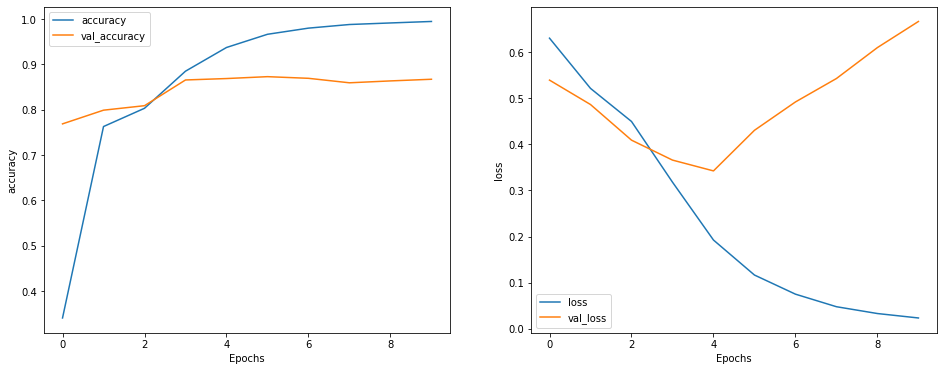

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

In [ ]:
# # !pip install pyarabic
# from pyarabic.araby import strip_harakat,strip_tatweel
# text = u"الْعَـــــــــرَبِ     يّةُ"
# strip_harakat(text)
# # strip_tatweel(text)
# re.sub(' +',